# Carga de Librerías necesarias y los Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import re
from wordcloud import WordCloud 

sns.set_theme(palette="muted")

In [2]:
# Cargo los datos que voy a usar.
df_steam_games = pd.read_parquet('..\\datasets\\2. Depurado\\steam_games_depurado.parquet')
df_users = pd.read_parquet('..\\datasets\\2. Depurado\\user_items_depurado.parquet')
df_reviews_TB = pd.read_parquet('..\\datasets\\2. Depurado\\user_reviews_NLP_TextBlob.parquet')
df_reviews_TF = pd.read_parquet('..\\datasets\\2. Depurado\\user_reviews_NLP_Transformers.parquet')

In [3]:
df_steam_games.describe()

,release_date,price,item_id,year
count,29781,30755.000000,32132.0,29781.000000
mean,2015-04-21 10:04:45.040797952,8.895293,451752.398512,2014.759175
min,1970-07-15 00:00:00,0.000000,10.0,1970.000000
25%,2014-10-01 00:00:00,2.990000,329277.5,2014.000000
50%,2016-04-18 00:00:00,4.990000,452030.0,2016.000000
75%,2017-04-17 00:00:00,9.990000,593392.5,2017.000000
max,2021-12-31 00:00:00,995.000000,2028850.0,2021.000000
std,NaN,16.338786,182714.677754,3.508269


In [4]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32132 entries, 0 to 32131
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     24081 non-null  object        
 1   genres        28850 non-null  object        
 2   app_name      32131 non-null  object        
 3   title         30083 non-null  object        
 4   url           32132 non-null  object        
 5   release_date  29781 non-null  datetime64[ns]
 6   tags          31970 non-null  object        
 7   reviews_url   32132 non-null  object        
 8   specs         31463 non-null  object        
 9   price         30755 non-null  float64       
 10  early_access  32132 non-null  bool          
 11  item_id       32132 non-null  Int64         
 12  developer     28834 non-null  object        
 13  free          32132 non-null  bool          
 14  year          29781 non-null  float64       
dtypes: Int64(1), bool(2), datetime64[ns]

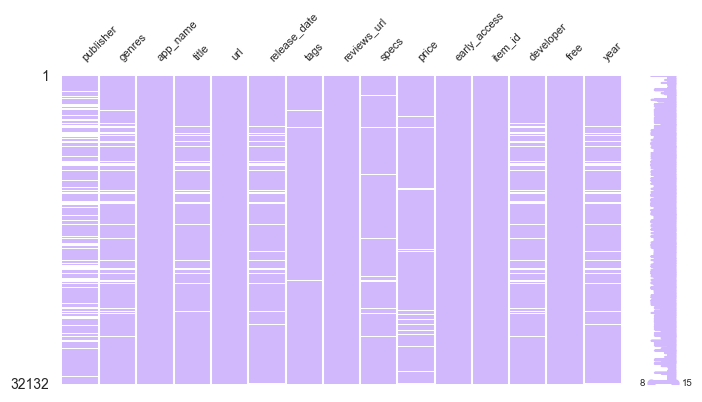

In [5]:
msno.matrix(df_steam_games, figsize=(8, 4), color=(0.823, 0.722, 0.992), fontsize=8)
plt.show()

---
# ANÁLISIS UNIVARIADO:

- Se realiza un histograma y un boxplot de precio para visualizar todos los valores en la búsqueda de outliers.

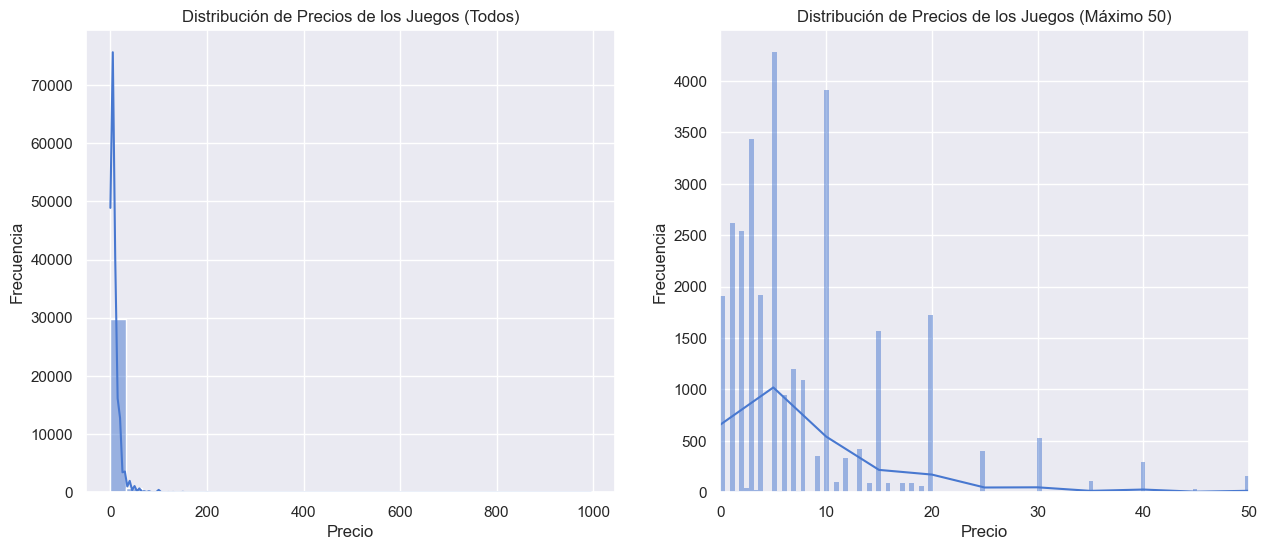

In [6]:
# Hago el histograma  para visulizarlo
# Creo la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Primer histograma con todos los precios
sns.histplot(df_steam_games['price'], bins = 30, kde = True, ax=axes[0])
axes[0].set_title('Distribución de Precios de los Juegos (Todos)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlabel('Precio')

# Segundo histograma recortado a un precio máximo de 20 - No fuerzo los bins, limito aa 50
sns.histplot(df_steam_games['price'], kde = True,  ax=axes[1])
axes[1].set_title('Distribución de Precios de los Juegos (Máximo 50)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_xlabel('Precio')
axes[1].set_xlim(0, 50)

plt.show()

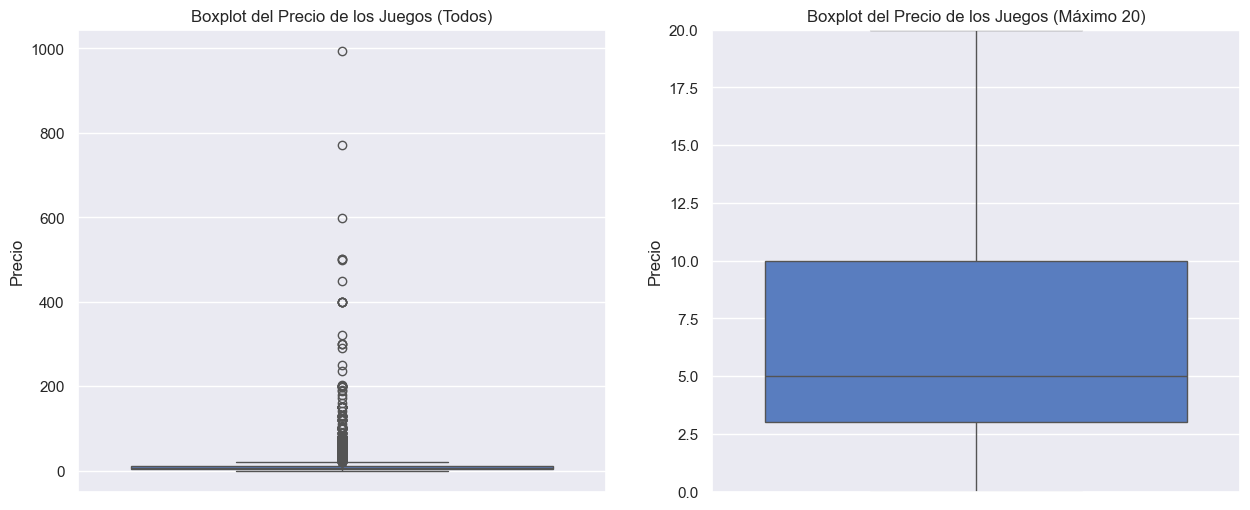

In [7]:
# Creo un boxplot para la columna 'price' usando seaborn
# Creo la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Primer boxplot con todos los precios
sns.boxplot(y=df_steam_games['price'], ax=axes[0])
axes[0].set_title('Boxplot del Precio de los Juegos (Todos)')
axes[0].set_ylabel('Precio')

# Segundo boxplot recortado a un precio máximo de 20
sns.boxplot(y=df_steam_games['price'], ax=axes[1])
axes[1].set_title('Boxplot del Precio de los Juegos (Máximo 20)')
axes[1].set_ylabel('Precio')
axes[1].set_ylim(0, 20)

# Mostrar los gráficos
plt.show()


- "price": si bien la media es baja, los valores extremos no parecieran estar errados, es razonable que un juego pueda valer 995 USD. Se verifica en la web.

<p align="center">
<img src="../_src/Juego_Más_Caro.PNG" height=400>
</p>

In [8]:
df_steam_games[df_steam_games['price'] == df_steam_games['price'].max()]['url']

12087    http://store.steampowered.com/app/719000/Strat...
Name: url, dtype: object

- Para el modelo de ML quiero usar genres, specs y tags, por lo tanto elimino los Nulos

In [9]:
# Reemplzo None con np.nan
df_steam_games['genres'] = df_steam_games['genres'].replace({None: np.nan})

# Elimino los nulos
df_steam_games.dropna(subset=['genres'], inplace=True)

# Reemplzo None con np.nan
df_steam_games['specs'] = df_steam_games['specs'].replace({None: np.nan})

# Elimino los nulos 
df_steam_games.dropna(subset=['specs'], inplace=True)

# Reemplzo None con np.nan
df_steam_games['tags'] = df_steam_games['tags'].replace({None: np.nan})

# Elimino los nulos 
df_steam_games.dropna(subset=['tags'], inplace=True)

- Cuento la cantidad de juegos por género, por specs y por tags:
    - Se observan valores que no son referidos al género del juego en sí mismo, como por ejemplo:
        - Free to play
        - Early Access
    - Se toma la decisión de unificar las columnas género, sepec y tags en una única "combinada" que será la referencia para el modelo de ML.
    - En esta columna no habrá repetición de características y se tomarán las 500 sepecs que más aparcen en el dataset.

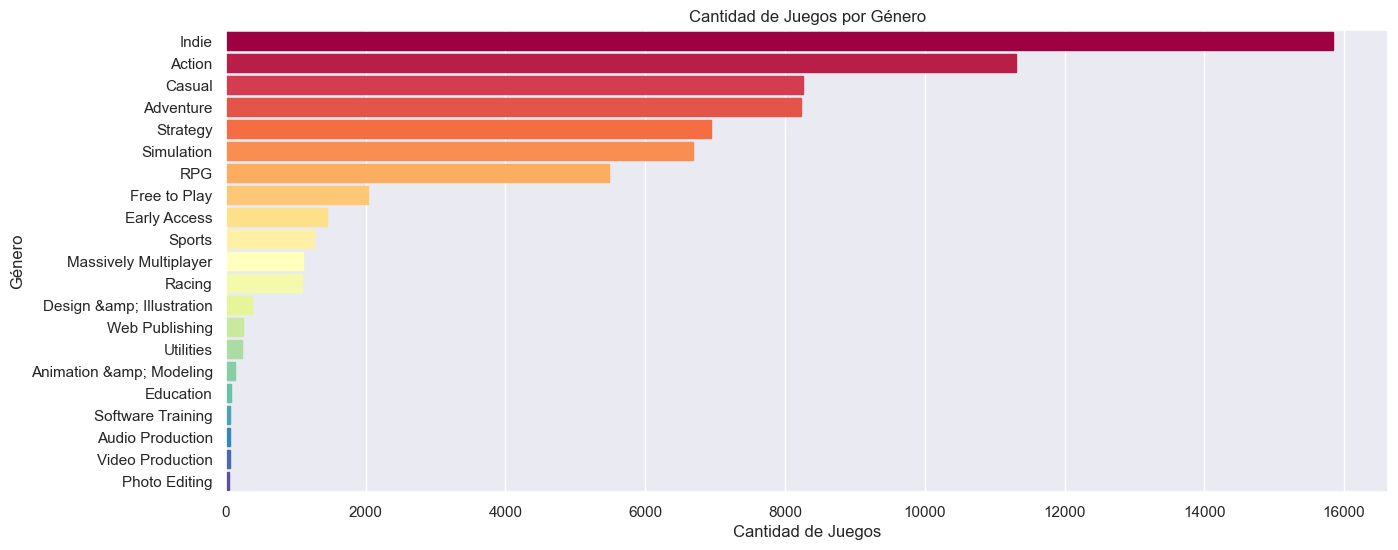

In [10]:
# Paso los géneros a una lista.
genre_counts = df_steam_games['genres'].explode().value_counts()

# Grafico la cantidad de jeugos por género
plt.figure(figsize=(15, 6))
plot = sns.barplot(x=genre_counts.values, y=genre_counts.index)

# Le aplico un degradé de colores
cmap = plt.get_cmap('Spectral') 
colors = cmap(np.linspace(0, 1, len(genre_counts.index)))
for i, bar in enumerate(plot.patches):
    bar.set_color(colors[i])


plt.title('Cantidad de Juegos por Género')
plt.xlabel('Cantidad de Juegos')
plt.ylabel('Género')
plt.show()


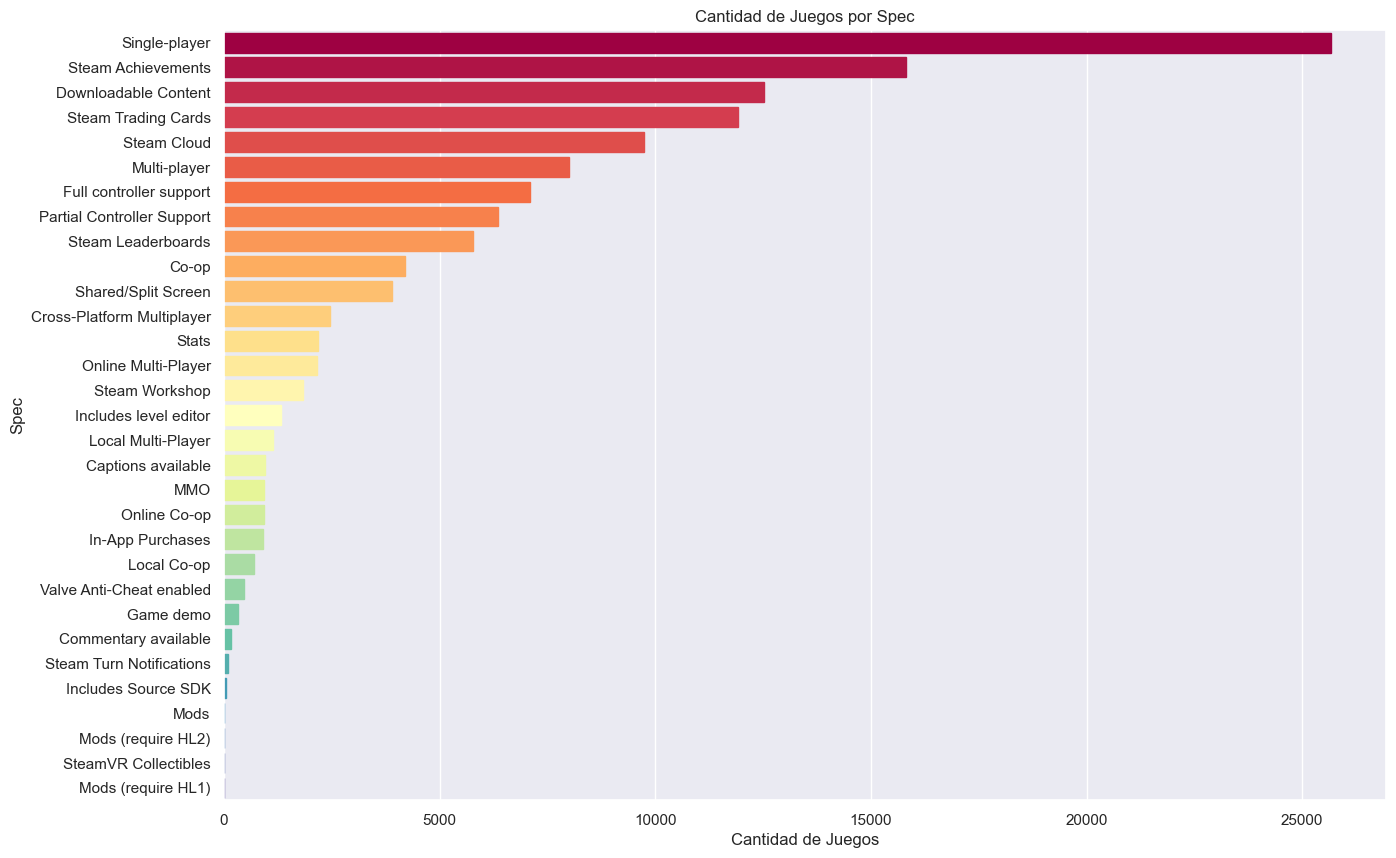

In [11]:
# Paso los specs a una lista.
spec_counts = df_steam_games['specs'].explode().value_counts()

# Grafico la cantidad de juegos por spec
plt.figure(figsize=(15, 10))
plot = sns.barplot(x=spec_counts.values, y=spec_counts.index)

# Le aplico un degradé de colores
cmap = plt.get_cmap('Spectral') 
colors = cmap(np.linspace(0, 1, len(spec_counts.index)))
for i, bar in enumerate(plot.patches):
    bar.set_color(colors[i])

plt.title('Cantidad de Juegos por Spec')
plt.xlabel('Cantidad de Juegos')
plt.ylabel('Spec')
plt.show()

- Como se puede observar, en tags que ya existen valores que se encuentran en specs y genres. Los voy a eliminar.

In [12]:
df_steam_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,False,2018.0
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,True,2018.0


- Realizo el tratamiento de las 3 columnas.

In [13]:
# Función para eliminar datos que ya existen en genres y en sepecs en la columna 'tags'
def remove_duplicate_tags(row):
    # Convertir los valores de genres, specs y tags a conjuntos y con la función set ya no pueden haber duplicados.
    genres_set = set(row['genres']) if isinstance(row['genres'], list) else set()
    specs_set = set(row['specs']) if isinstance(row['specs'], list) else set()
    tags_set = set(row['tags']) if isinstance(row['tags'], list) else set()

    # Restar los conjuntos de genres y specs de tags
    cleaned_tags = tags_set - genres_set - specs_set
    
    # Si cleaned_tags está vacío, devuelvo una lista vacía, de lo contrario, devuelvo la lista de cleaned_tags
    return list(cleaned_tags) if cleaned_tags else []


# Elimino "Free to Play" y "Early Access" de la listas de género y se convierte a lista
df_steam_games['genres'] = df_steam_games['genres'].apply(lambda x: [genre for genre in x if (genre != 'Free to Play' and genre != 'Early Access')])

# Convierto specs y tags a listas para poder manejar las diferencias con una resta.
df_steam_games['specs'] = df_steam_games['specs'].apply(lambda x: [specs for specs in x ])
df_steam_games['tags'] = df_steam_games['tags'].apply(lambda x: [specs for specs in x ])

# Aplicar la función a cada fila del DataFrame
df_steam_games['tags_new'] = df_steam_games.apply(remove_duplicate_tags, axis=1)

In [14]:
df_steam_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year,tags_new
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,False,2018.0,[]
1,"Making Fun, Inc.","[Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,True,2018.0,"[Competitive, Character Customization, Card Ga..."


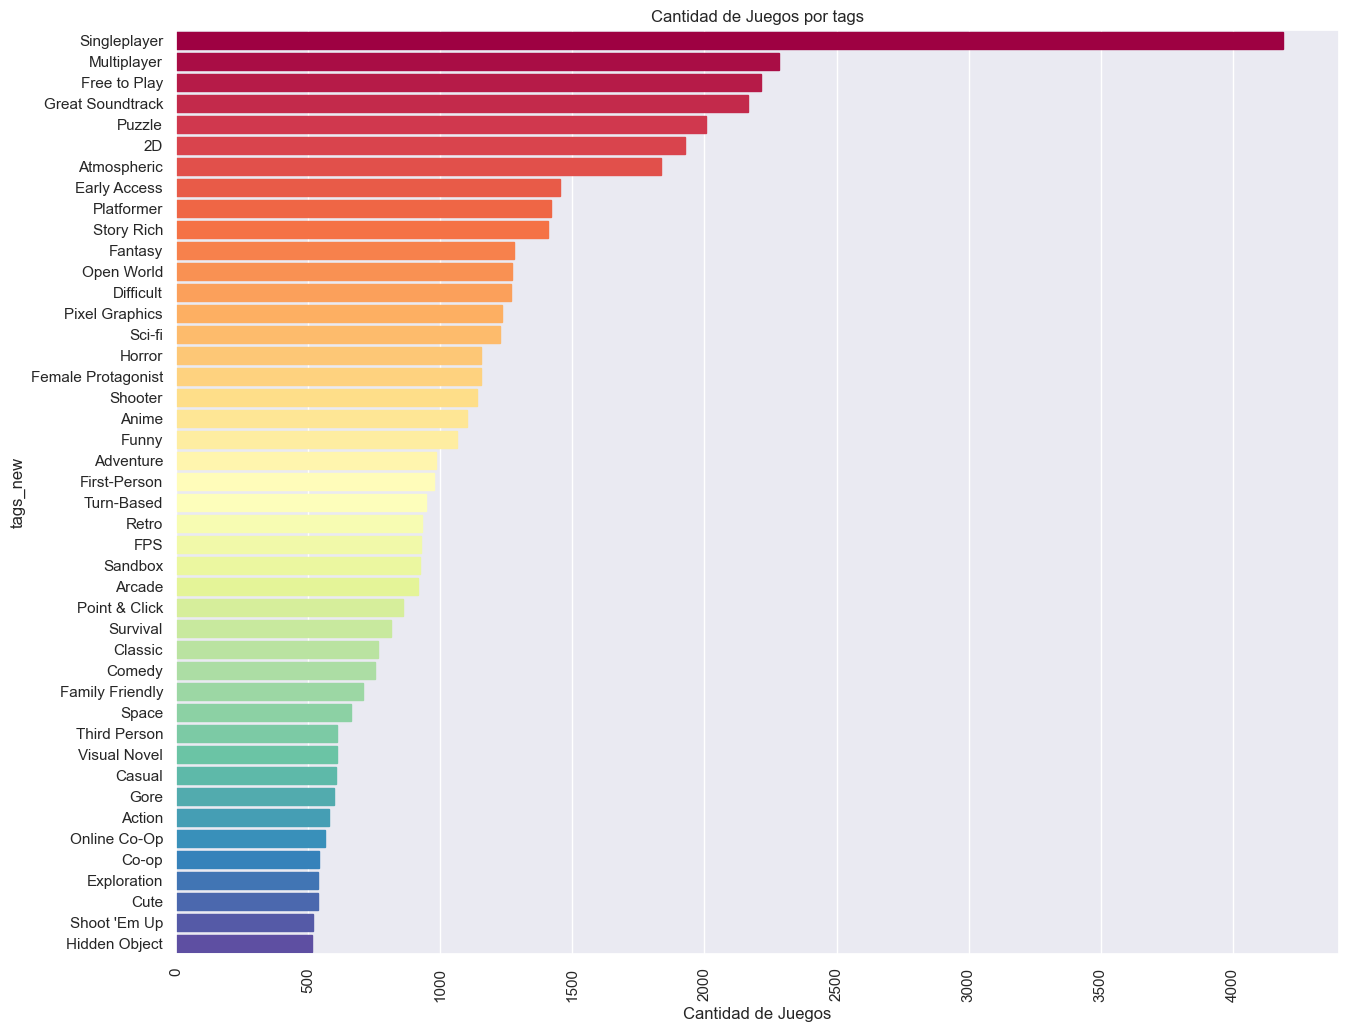

In [15]:
# Paso los tags a una lista.
tags_counts = df_steam_games['tags_new'].explode().value_counts()

# Me quedo con los valores mayores a 500
tags_counts = tags_counts[tags_counts > 500]

# Grafico la cantidad de juegos por tags
plt.figure(figsize=(15, 12))
plot = sns.barplot(x=tags_counts.values, y=tags_counts.index)

# Le aplico un degradé de colores
cmap = plt.get_cmap('Spectral') 
colors = cmap(np.linspace(0, 1, len(tags_counts.index)))
for i, bar in enumerate(plot.patches):
    bar.set_color(colors[i])

plt.xticks(rotation=90)
plt.title('Cantidad de Juegos por tags')
plt.xlabel('Cantidad de Juegos')
plt.ylabel('tags_new')
plt.show()

In [16]:
# Creo una lista de tags que aparecen  más de 500 veces en todo el dataset
valid_tags = set(genre_counts.index)

# Creo una función para filtrar los tags
def filter_tags(tags):
    # Verifico que sea una  lista
    if isinstance(tags, list): 
        
        # Filtrar los tags que no están en valid_tags
        return [tag for tag in tags if tag in valid_tags]
    
    # Devolver sin cambios si no es una lista
    return tags  

# Aplicar la función de filtrado a la columna 'tags_new'
df_steam_games['tags_new'] = df_steam_games['tags_new'].apply(filter_tags)

In [17]:
df_steam_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year,tags_new
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,False,2018.0,[]
1,"Making Fun, Inc.","[Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,True,2018.0,[Free to Play]


In [18]:
# Convierto los array para poder procesarlos con TfidfVectorizer
df_steam_games['genres_str'] = df_steam_games['genres'].apply(lambda x: ' '.join(x))
df_steam_games['specs_str'] = df_steam_games['specs'].apply(lambda x: ' '.join(x))
df_steam_games['tags_str'] = df_steam_games['tags_new'].apply(lambda x: ' '.join(x))

# Combino las columnas que quiero vectorizar para el cálculo de la matriz del coseno
df_steam_games['combined'] = df_steam_games['genres_str'] + ' ' +  df_steam_games['specs_str'] + ' ' + df_steam_games['tags_str'] 
# Tiro genres_str, specs_str y tags_str
df_steam_games = df_steam_games.drop(['genres_str', 'specs_str', 'tags_str'], axis=1)

- Analizo la cantidad de juegos por año de publicación. No es algo que me resulte útil a mnenos que quiera achicar el dataset.

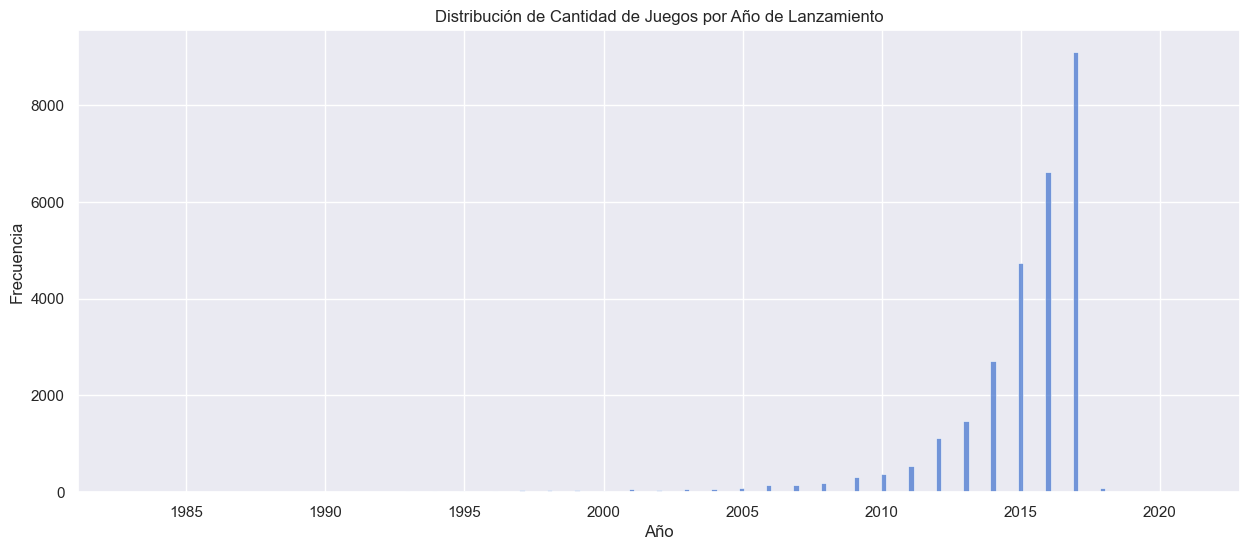

In [19]:
plt.figure(figsize=(15, 6))
sns.histplot(df_steam_games['year'])
plt.title('Distribución de Cantidad de Juegos por Año de Lanzamiento')
plt.ylabel('Frecuencia')
plt.xlabel('Año')
plt.show()

- "release_date" tiene fechas razonables. Se presentaron dudas sobre la fecha más vieja, 15/07/1970, pero se verifica en la web.

<p align="center">
<img src="../_src/Juego_Más_Viejo.PNG" height=400>
</p>

In [20]:
df_steam_games[df_steam_games['release_date'] == df_steam_games['release_date'].min()]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,item_id,developer,free,year,tags_new,combined
1376,Digital Leisure Inc.,"[Action, Adventure, Casual]",Dragon's Lair,Dragon's Lair,http://store.steampowered.com/app/227380/Drago...,1983-06-19,"[Adventure, Action, FMV, Casual, Quick-Time Ev...",http://steamcommunity.com/app/227380/reviews/?...,"[Single-player, Steam Achievements, Partial Co...",9.99,False,227380,Digital Leisure Inc.,False,1983.0,[],Action Adventure Casual Single-player Steam Ac...


- Antes de agregar métricas para el análisis de resultados, comparo el NLP obtenido con TextBlob y con Transformers-
    - A simple vista pareciera que Transformers preseta 
        - Más cantidad de comentarios con recommend = True como Positivos, 
        - Menos con recommend = False como Positivos,
        - Más con recommend = False como Negativos
        - Sin embargo presenta más clasificaciones Negativas para reviews con recommend = True que TextBlob.
- Se decide tomar el de Transformers.

In [21]:
# Me saeguro de que las recomendaciones estén bien categorizadas en un DF copiado
df_reviews_TB_copy = df_reviews_TB.copy()
df_reviews_TF_copy = df_reviews_TF.copy()
df_reviews_TB_copy['recommend'] = df_reviews_TB_copy['recommend'].map({True: 'Recommended', False: 'Not Recommended'})
df_reviews_TF_copy['recommend'] = df_reviews_TF_copy['recommend'].map({True: 'Recommended', False: 'Not Recommended'})

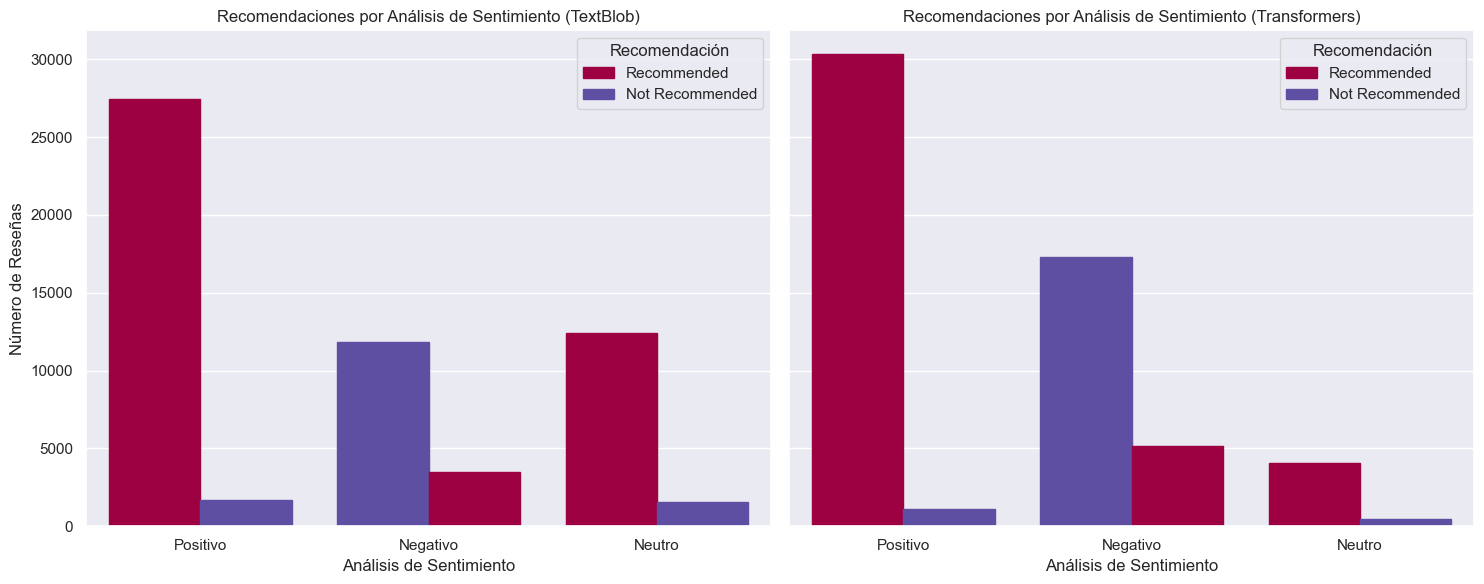

In [22]:
# Creo la figura con dos subplots, uno para cada gráfico
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Le aplico un degradé de colores
cmap = plt.get_cmap('Spectral') 
colors = cmap(np.linspace(0, 1, 2))  # Hay 2 categorías en 'recommend'

# Gráfico para TextBlob en el subplot de la izquierda
plot_TB = sns.countplot(data=df_reviews_TB_copy, x='sentiment', hue='recommend', ax=axes[0])

# Asigno colores a las barras
for i, bar in enumerate(plot_TB.patches):
    bar.set_color(colors[i % 2])  # Se alternan los colores por recomendación

axes[0].set_title('Recomendaciones por Análisis de Sentimiento (TextBlob)')
axes[0].set_xlabel('Análisis de Sentimiento')
axes[0].set_ylabel('Número de Reseñas')
axes[0].legend(title='Recomendación')

# Gráfico para Transformers en el subplot de la derecha
plot_TF = sns.countplot(data=df_reviews_TF_copy, x='sentiment', hue='recommend', ax=axes[1])

# Asigno colores a las barras
for i, bar in enumerate(plot_TF.patches):
    bar.set_color(colors[i % 2])  # Se alternan los colores por recomendación


axes[1].set_title('Recomendaciones por Análisis de Sentimiento (Transformers)')
axes[1].set_xlabel('Análisis de Sentimiento')
axes[1].legend(title='Recomendación')
axes[1].set_ylabel('')

# Ajustar los gráficos para que no se sobrepongan
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [23]:
df_reviews_TF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            58431 non-null  object
 1   user_url           58431 non-null  object
 2   item_id            58431 non-null  Int64 
 3   posted             58431 non-null  object
 4   helpful            58431 non-null  object
 5   recommend          58431 non-null  bool  
 6   funny              58431 non-null  object
 7   review             58431 non-null  object
 8   processed_reviews  58431 non-null  object
 9   sentiment          58431 non-null  object
 10  sentiment_value    58431 non-null  object
dtypes: Int64(1), bool(1), object(9)
memory usage: 4.6+ MB


- Análisis de Outliers de tiempo jugado.
    - Graficamos un boxplot para observar los
    - Verifico manualmente los valore más elevados y son coincidentes con lo que figura en la web. 
    - Como ejemplo, el máximo no está público pero el segundo más alto sí 

<p align="center">
<img src="../_src/Mayor_Tiempo_de_Juego.PNG" height=400>
</p>

In [24]:
df_users.describe()

,item_id,playtime_forever,playtime_2weeks
count,5094082.0,5.094082e+06,5.094082e+06
mean,178391.45484,9.905071e+02,9.065419e+00
std,131851.395185,5.414098e+03,1.402840e+02
min,10.0,0.000000e+00,0.000000e+00
25%,34450.0,0.000000e+00,0.000000e+00
50%,214420.0,3.400000e+01,0.000000e+00
75%,266430.0,3.550000e+02,0.000000e+00
max,530720.0,6.427730e+05,1.996700e+04


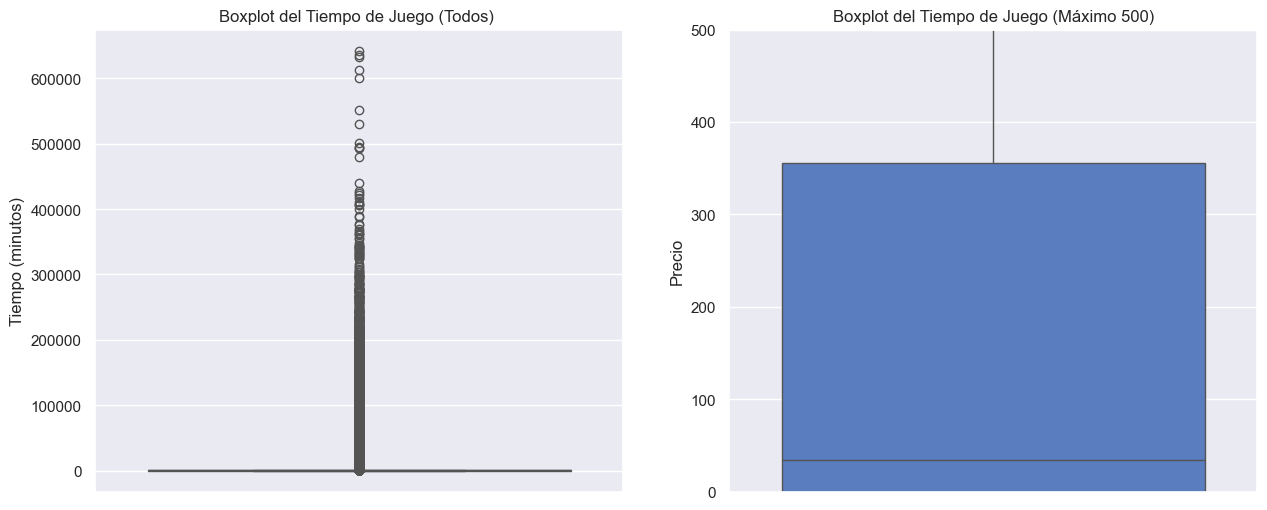

In [25]:
# Creo un boxplot para la columna 'price' usando seaborn
# Creo la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Primer boxplot con todos los precios
sns.boxplot(y=df_users['playtime_forever'], ax=axes[0])
axes[0].set_title('Boxplot del Tiempo de Juego (Todos) ')
axes[0].set_ylabel('Tiempo (minutos)')

# Segundo boxplot recortado a un precio máximo de 20
sns.boxplot(y=df_users['playtime_forever'], ax=axes[1])
axes[1].set_title('Boxplot del Tiempo de Juego (Máximo 500)')
axes[1].set_ylabel('Precio')
axes[1].set_ylim(0, 500)

# Mostrar los gráficos
plt.show()

In [26]:
df_users.sort_values(by='playtime_forever', ascending=False)

,user_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
5025703,wolop,http://steamcommunity.com/id/wolop,4000,Garry's Mod,642773.0,7299.0
2584428,Evilutional,http://steamcommunity.com/id/Evilutional,212200,Mabinogi,635295.0,0.0
476737,76561198019826668,http://steamcommunity.com/profiles/76561198019...,42710,Call of Duty: Black Ops - Multiplayer,632452.0,8126.0
739729,76561198039832932,http://steamcommunity.com/profiles/76561198039...,4000,Garry's Mod,613411.0,588.0
4949471,tsunamitad,http://steamcommunity.com/id/tsunamitad,72200,Universe Sandbox,600068.0,0.0
...,...,...,...,...,...,...
2960357,Murderousbinkie,http://steamcommunity.com/id/Murderousbinkie,32500,STAR WARS™: The Force Unleashed™ II,0.0,0.0
2960358,Murderousbinkie,http://steamcommunity.com/id/Murderousbinkie,32800,The Lord of the Rings: War in the North,0.0,0.0
2960359,Murderousbinkie,http://steamcommunity.com/id/Murderousbinkie,33220,Tom Clancy's Splinter Cell: Conviction,0.0,0.0
2960360,Murderousbinkie,http://steamcommunity.com/id/Murderousbinkie,33460,From Dust,0.0,0.0


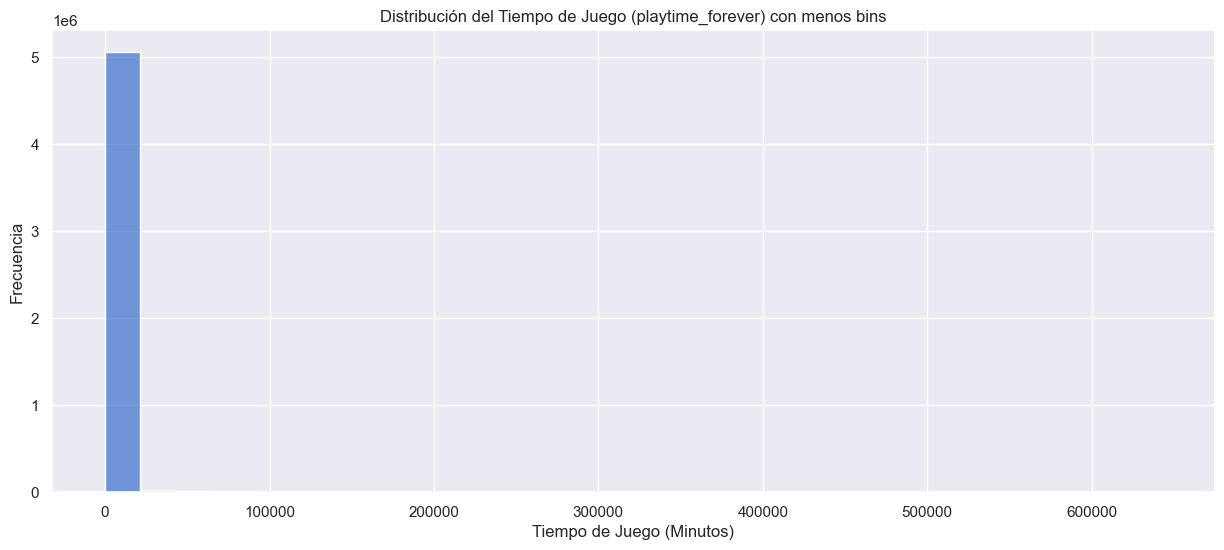

In [27]:
# Crear el histograma con menos bins
plt.figure(figsize=(15, 6))
sns.histplot(df_users['playtime_forever'], bins=30)  # Menos bins para menos detalle
plt.title('Distribución del Tiempo de Juego (playtime_forever) con menos bins')
plt.xlabel('Tiempo de Juego (Minutos)')
plt.ylabel('Frecuencia')
plt.show()

- Agrego algunas métricas al df de steam_game para poder analizar otros resultados que podrían servir para el ML.

In [28]:
# Voy a calcular métricas a partir de las reviews para cada juego.
# Calculo la cantidad de sentimientos "Positivos", "Neutros" y "Negativos" para cada juego
sentiment_counts = df_reviews_TF.groupby('item_id')['sentiment'].value_counts().unstack(fill_value=0)

# Calculo el total de reviews por juego (por columna)
sentiment_counts['total_reviews'] = sentiment_counts.sum(axis=1)

# Calculo la proporción de reviews por tipo de sentimiento por juego
sentiment_counts['positive_ratio'] = sentiment_counts.get('Positivo', 0) / sentiment_counts['total_reviews']
sentiment_counts['neutral_ratio'] = sentiment_counts.get('Neutro', 0) / sentiment_counts['total_reviews']
sentiment_counts['negative_ratio'] = sentiment_counts.get('Negativo', 0) / sentiment_counts['total_reviews']

# También necesito el total_reviews porque sino un juego que tiene una sola review positvia tiene un positive_ratio de 1.
# Voy a joinear las métricas de sentimiento al dataframe de juegos
df_steam_games = df_steam_games.merge(sentiment_counts[['positive_ratio', 'neutral_ratio', 'negative_ratio','total_reviews']], on='item_id', how='left')

In [29]:
# Calculo la catidad de Recomendaciones "True" y "False"
recomends_counts = df_reviews_TF.groupby('item_id')['recommend'].value_counts().unstack(fill_value=0)

# Calculo el total de reviews por juego (por columna)
recomends_counts['total_recommend'] = sentiment_counts.sum(axis=1)

# Calculo la proporción de reviews por tipo de sentimiento por juego
recomends_counts['true_ratio'] = recomends_counts.get(True, 0) / recomends_counts['total_recommend']
recomends_counts['false_ratio'] = recomends_counts.get(False, 0) / recomends_counts['total_recommend']

# También necesito el total_reviews porque sino un juego que tiene una sola review positvia tiene un positive_ratio de 1.
# Voy a joinear las métricas de sentimiento al dataframe de juegos
df_steam_games = df_steam_games.merge(recomends_counts[['true_ratio', 'false_ratio','total_recommend']], on='item_id', how='left')

In [30]:
# # Voy a calcular la cantidad de TOTAL de tiempo jugado entre todos los user_id para cada juego
total_time = df_users.groupby('item_id')['playtime_forever'].sum()

# Voy a joinear las métricas de tiempo al dataframe de juegos
df_steam_games = df_steam_games.merge(total_time, on='item_id', how='left')

- Análisis de juegos más jugados:

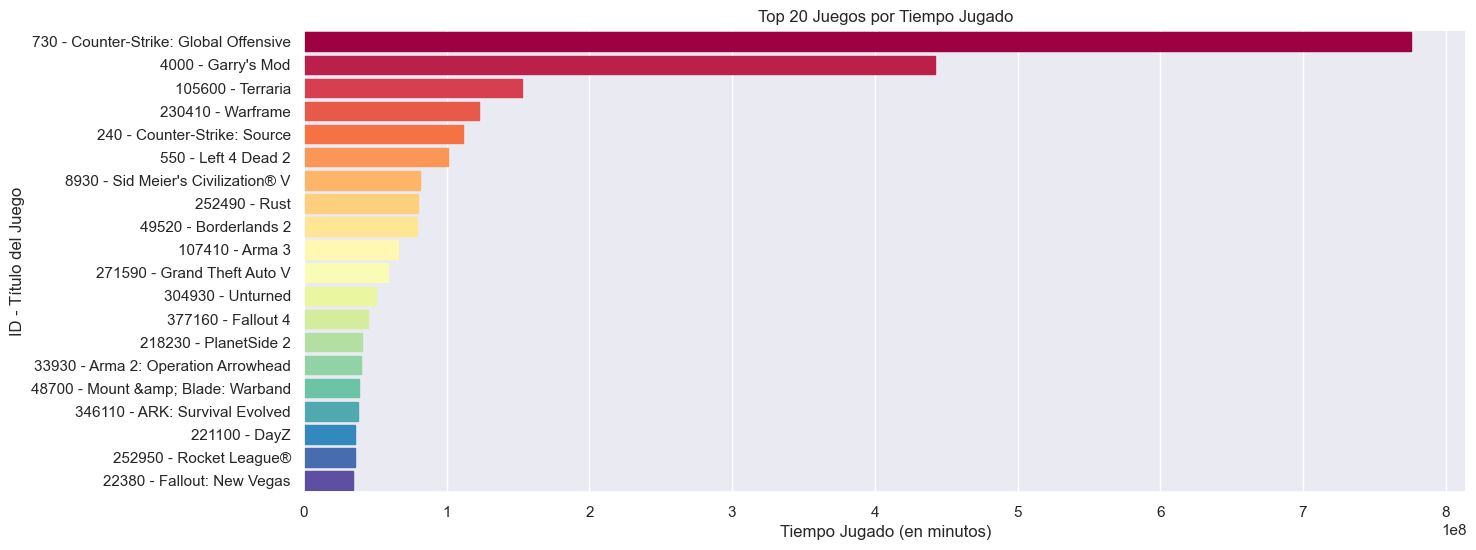

In [31]:
# Ordeno el DataFrame por 'playtime_forever' y seleccionar los primeros 20 juegos
top_20_playtime = df_steam_games.sort_values(by='playtime_forever', ascending=False).head(20)

# Crear una nueva columna que combine 'item_id' y 'title'
top_20_playtime['game_label'] = top_20_playtime['item_id'].astype(str) + ' - ' + top_20_playtime['title']

# Graficar la cantidad de tiempo por juego
plt.figure(figsize=(15, 6))
plot= sns.barplot(x=top_20_playtime['playtime_forever'] , y=top_20_playtime['game_label'] )

# Le aplico un degradé de colores
cmap = plt.get_cmap('Spectral') 
colors = cmap(np.linspace(0, 1, len(top_20_playtime.index)))
for i, bar in enumerate(plot.patches):
    bar.set_color(colors[i])
    
plt.title('Top 20 Juegos por Tiempo Jugado')
plt.xlabel('Tiempo Jugado (en minutos)')
plt.ylabel('ID - Título del Juego')
plt.show()

- Análsis de juegos con más cantidad de reviews positivas

In [32]:
df_steam_games.describe()

,release_date,price,item_id,year,positive_ratio,neutral_ratio,negative_ratio,total_reviews,true_ratio,false_ratio,total_recommend,playtime_forever
count,28239,27329.000000,28542.0,28239.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000,8.560000e+03
mean,2015-05-24 21:18:30.251779584,8.683993,440794.73821,2014.848649,0.499279,0.076899,0.423822,16.118754,0.328448,0.075155,33.237508,5.022935e+05
min,1983-06-19 00:00:00,0.000000,10.0,1983.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000e+00
25%,2014-10-23 00:00:00,2.990000,317722.5,2014.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.000000,3.000000,5.337500e+02
50%,2016-04-22 00:00:00,4.990000,435105.5,2016.000000,0.500000,0.000000,0.375000,2.000000,0.333333,0.000000,5.000000,4.844000e+03
75%,2017-04-19 00:00:00,9.990000,586317.5,2017.000000,0.872917,0.054983,0.666667,7.000000,0.428571,0.115241,15.000000,2.486125e+04
max,2021-12-31 00:00:00,995.000000,2028850.0,2021.000000,1.000000,1.000000,1.000000,3708.000000,0.498316,0.454545,7417.000000,7.757848e+08
std,NaN,14.644351,185186.713436,3.271175,0.375484,0.201485,0.371534,109.807070,0.133998,0.117077,219.614139,1.033079e+07


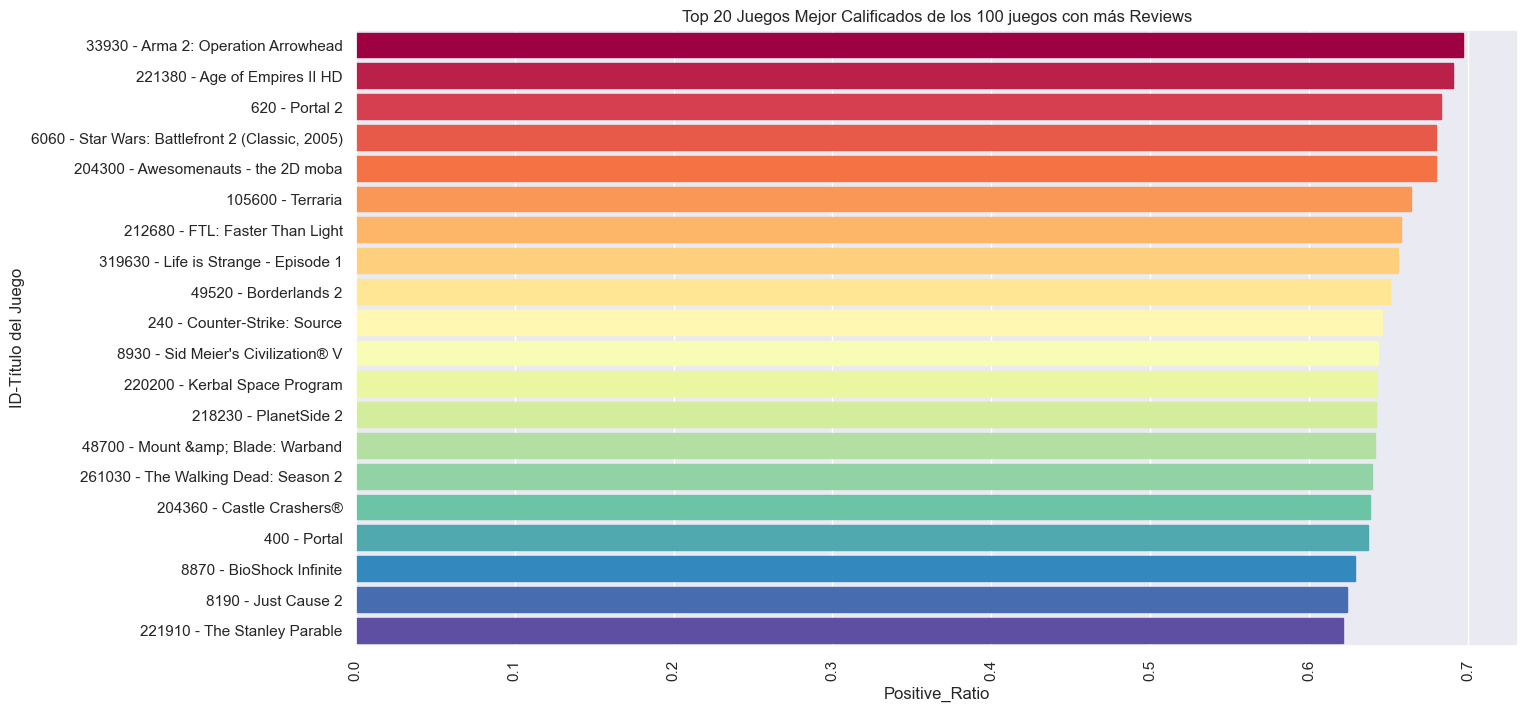

In [33]:
# Primero me quedo con los 100 juegos con más reviews
top_20_count_reviews = df_steam_games.sort_values(by='total_reviews', ascending=False).head(100)

# Los ordeno por mejor ratio positivo y me quedo con los mejores 20
top_20_count_reviews = top_20_count_reviews.sort_values(by='positive_ratio', ascending=False).head(20)

# Crear una nueva columna que combine 'item_id' y 'title'
top_20_count_reviews['game_label'] = top_20_count_reviews['item_id'].astype(str) + ' - ' + top_20_count_reviews['title']

# Graficar la cantidad de tiempo por juego
plt.figure(figsize=(15, 8))
plot = sns.barplot(x=top_20_count_reviews['positive_ratio']  , y=top_20_count_reviews['game_label'])

# Le aplico un degradé de colores
cmap = plt.get_cmap('Spectral') 
colors = cmap(np.linspace(0, 1, len(top_20_count_reviews.index)))
for i, bar in enumerate(plot.patches):
    bar.set_color(colors[i])

plt.xticks(rotation=90)
plt.title('Top 20 Juegos Mejor Calificados de los 100 juegos con más Reviews')
plt.xlabel('Positive_Ratio')
plt.ylabel('ID-Título del Juego')
plt.show()

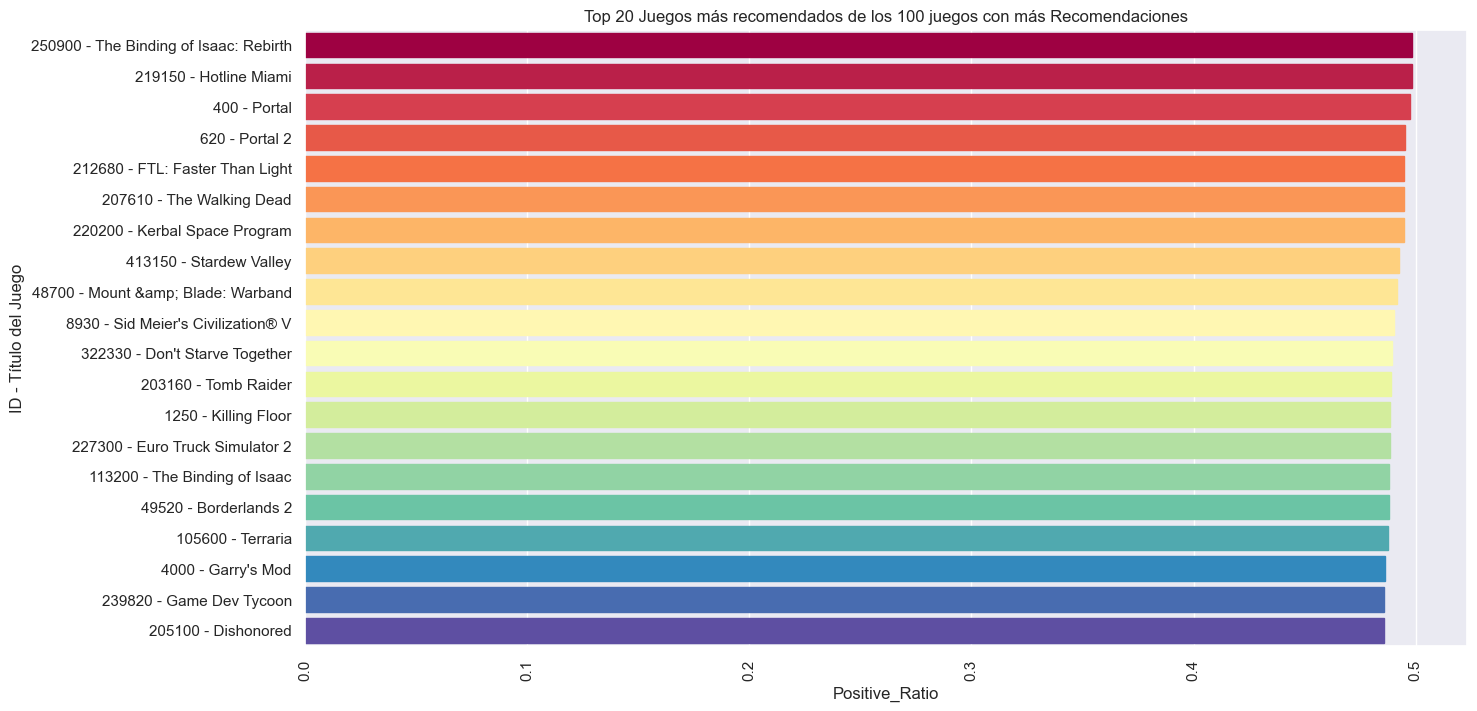

In [34]:
# Primero me quedo con los 100 juegos con más reviews
top_20_count_reviews = df_steam_games.sort_values(by='total_recommend', ascending=False).head(100)

# Los ordeno por mejor ratio positivo y me quedo con los mejores 20
top_20_count_reviews = top_20_count_reviews.sort_values(by='true_ratio', ascending=False).head(20)

# Crear una nueva columna que combine 'item_id' y 'title'
top_20_count_reviews['game_label'] = top_20_count_reviews['item_id'].astype(str) + ' - ' + top_20_count_reviews['title']

# Graficar la cantidad de tiempo por juego
plt.figure(figsize=(15, 8))
plot = sns.barplot(x=top_20_count_reviews['true_ratio'] , y=top_20_count_reviews['game_label'])

# Le aplico un degradé de colores
cmap = plt.get_cmap('Spectral') 
colors = cmap(np.linspace(0, 1, len(top_20_playtime.index)))
for i, bar in enumerate(plot.patches):
    bar.set_color(colors[i])

plt.xticks(rotation=90)
plt.title('Top 20 Juegos más recomendados de los 100 juegos con más Recomendaciones')
plt.xlabel('Positive_Ratio')
plt.ylabel('ID - Título del Juego')
plt.show()

# ANÁLISIS MULTIVARIABLE:

- De la matriz de correlaciones sólo se observa una leve correlación lineal con el total de reviews y el total de horas jugadas de cada juego.
- Buscamos a ver si encontramos correlaciones no lineales graficando el pairplot.

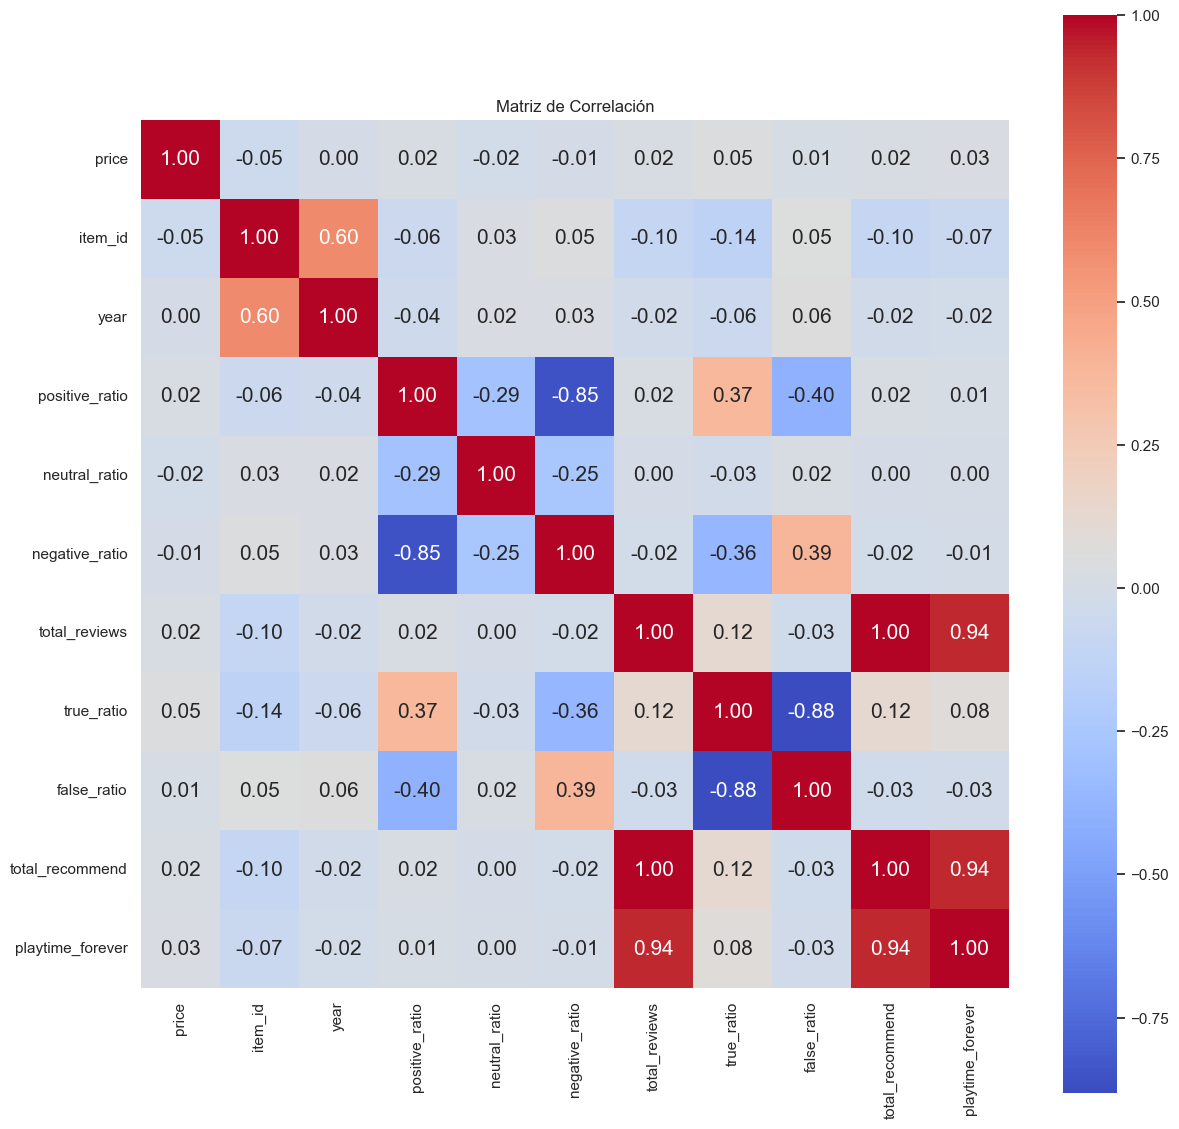

In [35]:
# Selecciono sólo las columnas numéricas
numerical_df = df_steam_games.select_dtypes(include=['float64', 'int64'])

# Calculo la matriz de correlación
correlation_matrix = numerical_df.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap='coolwarm',
            xticklabels= numerical_df.columns,
            yticklabels= numerical_df.columns,)
plt.title('Matriz de Correlación')
plt.show()


<Figure size 1400x1400 with 0 Axes>

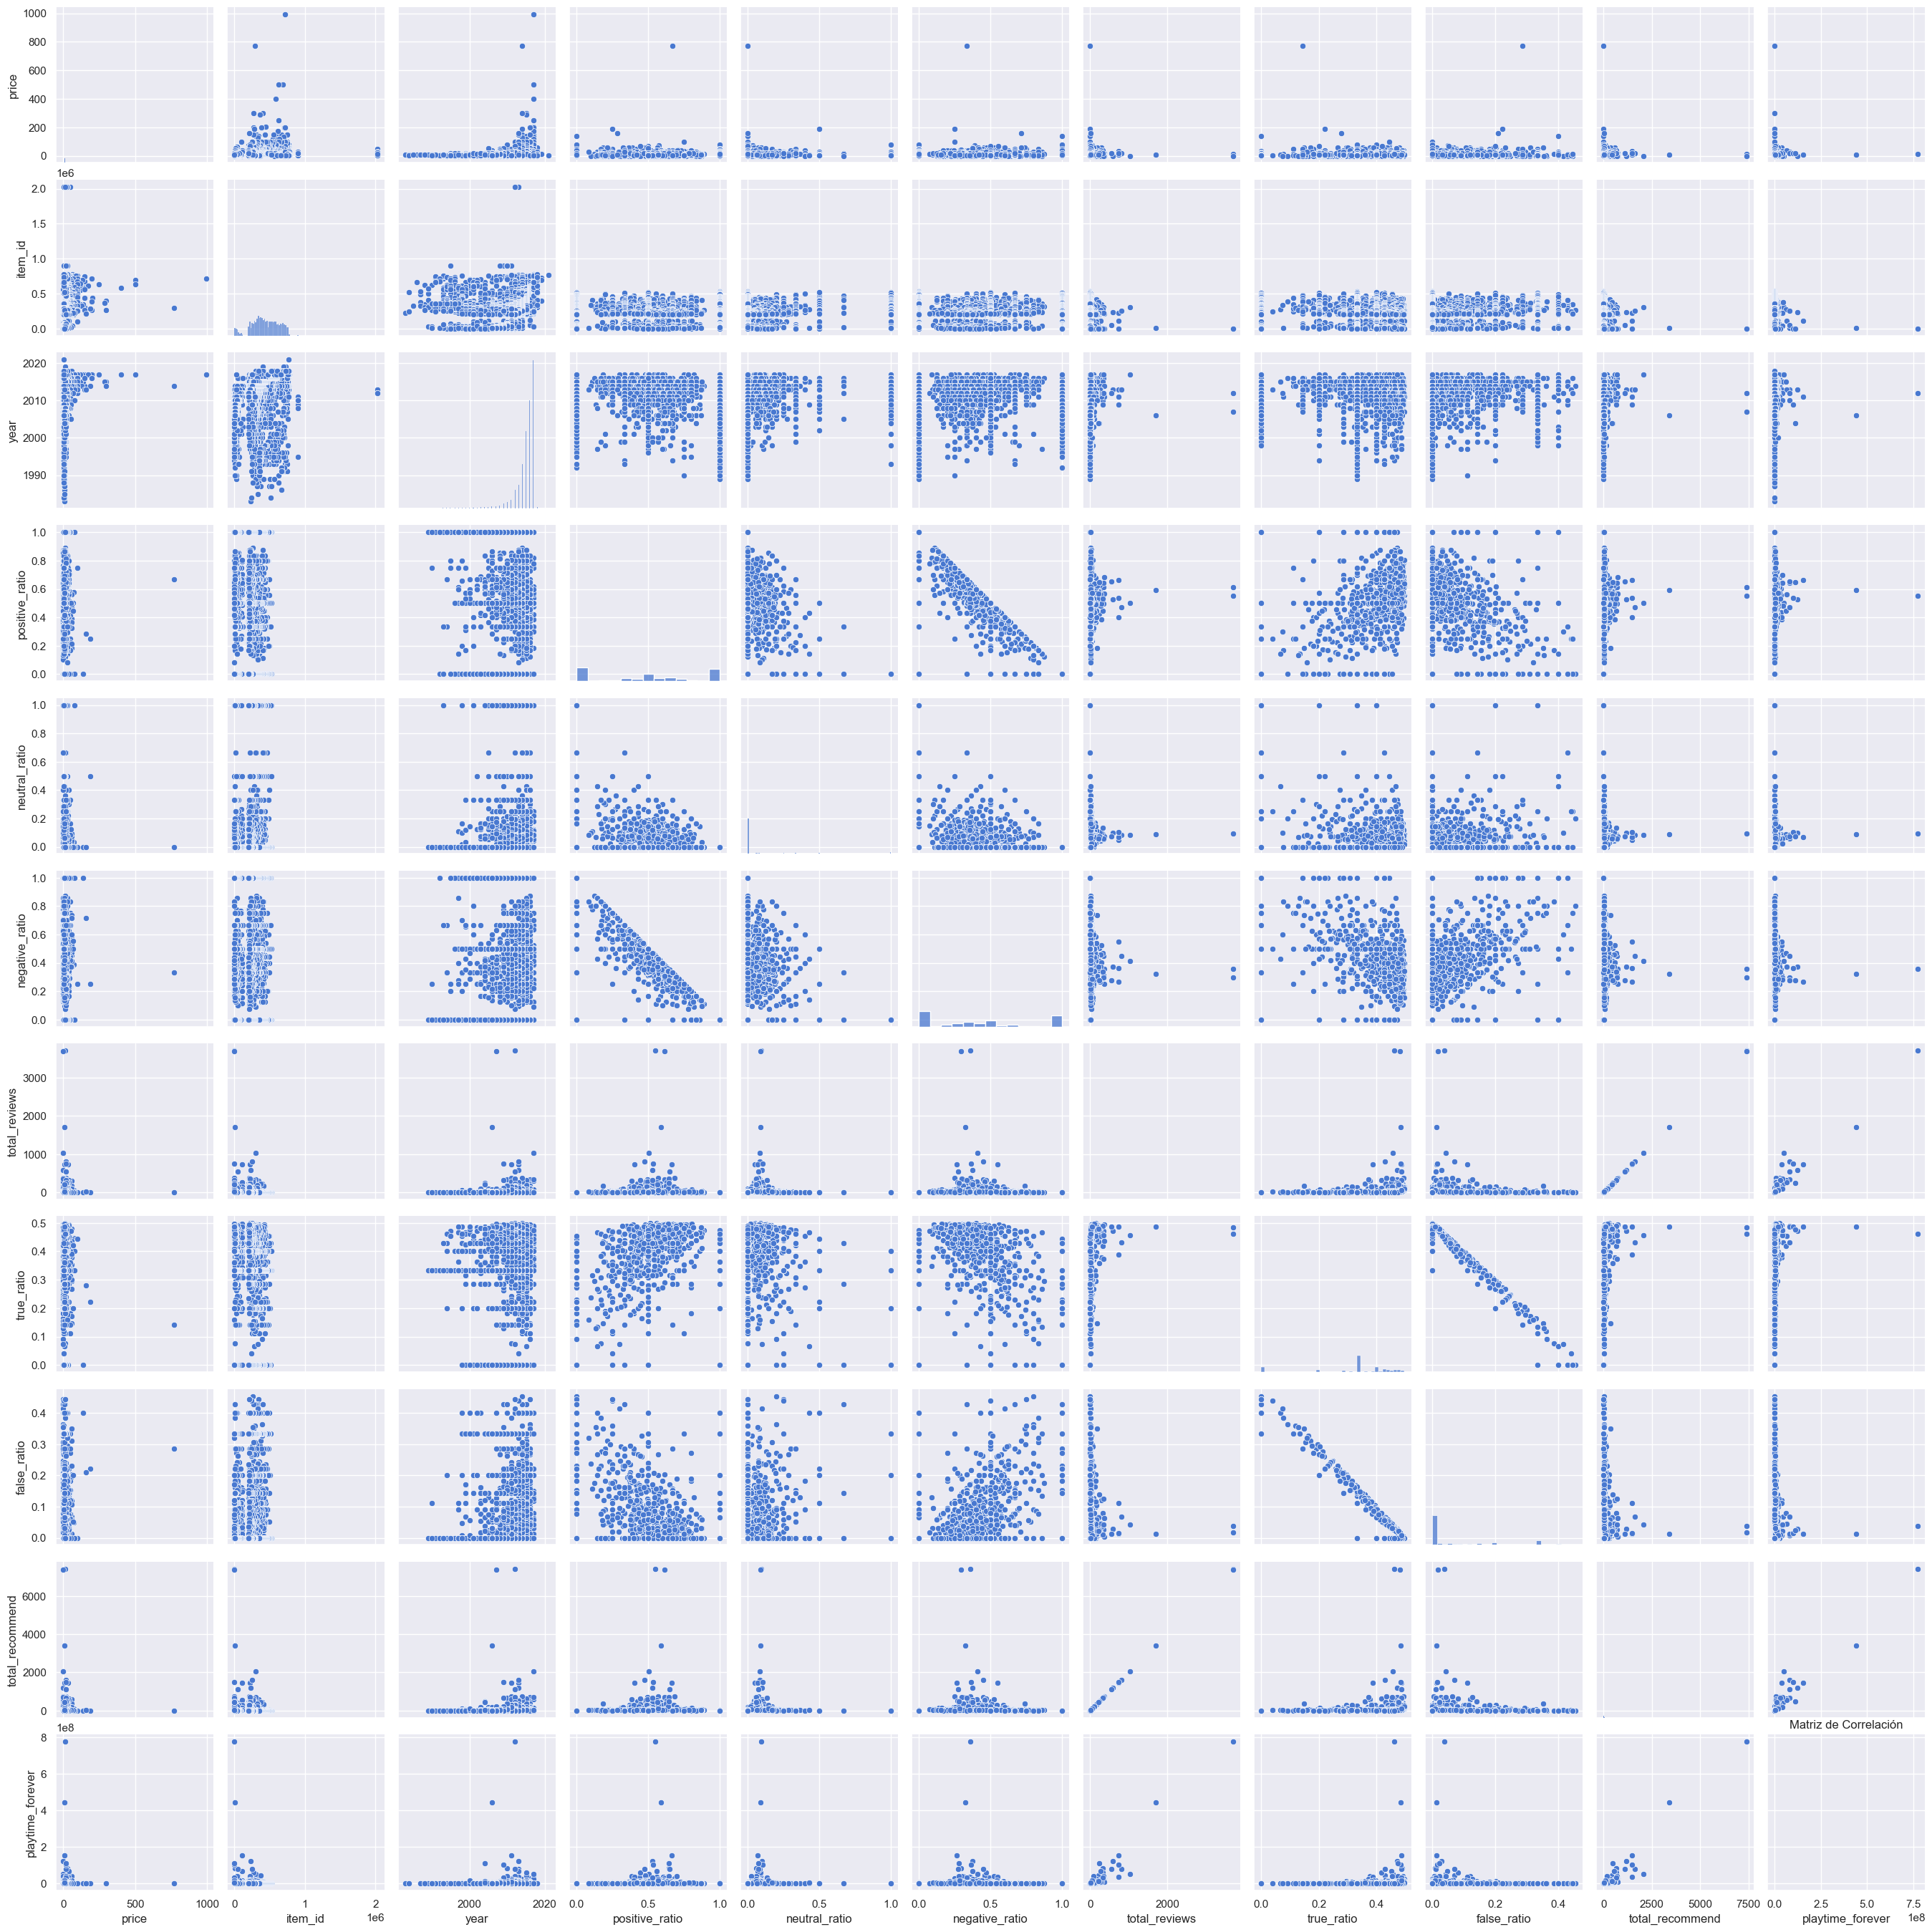

In [36]:
# Graficar 
plt.figure(figsize=(14, 14))
sns.pairplot(numerical_df)
plt.title('Matriz de Correlación')
plt.show()


- Análisis de positive_ratio vs true_ratio y de negative_ratio vs false_ratio

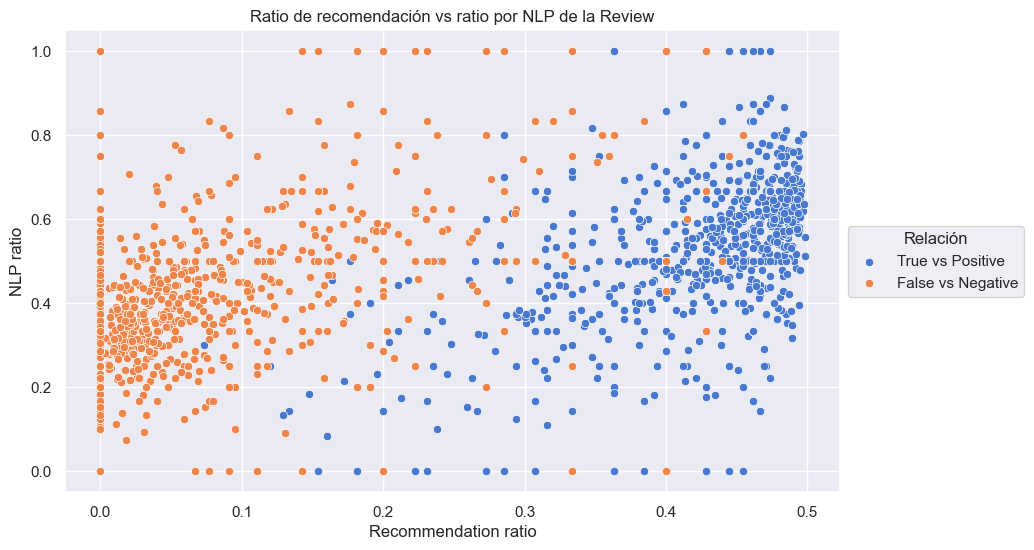

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'true_ratio', y='positive_ratio', data = df_steam_games, label='True vs Positive')
sns.scatterplot(x= 'false_ratio', y='negative_ratio', data = df_steam_games, label='False vs Negative') 
plt.title('Ratio de recomendación vs ratio por NLP de la Review')
plt.xlabel('Recommendation ratio')
plt.ylabel('NLP ratio')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Relación')
plt.show()

- Análisis de precio vs positive_ratio

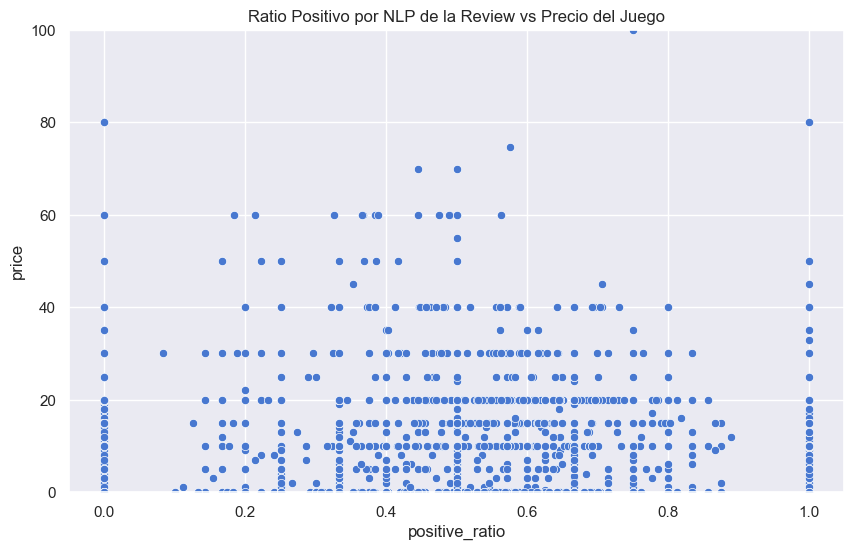

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'positive_ratio', y='price', data = df_steam_games)
plt.title('Ratio Positivo por NLP de la Review vs Precio del Juego')
plt.xlabel('positive_ratio')
plt.ylabel('price')
plt.ylim(0,100)
plt.show()

- Análisis de precio vs true_ratio

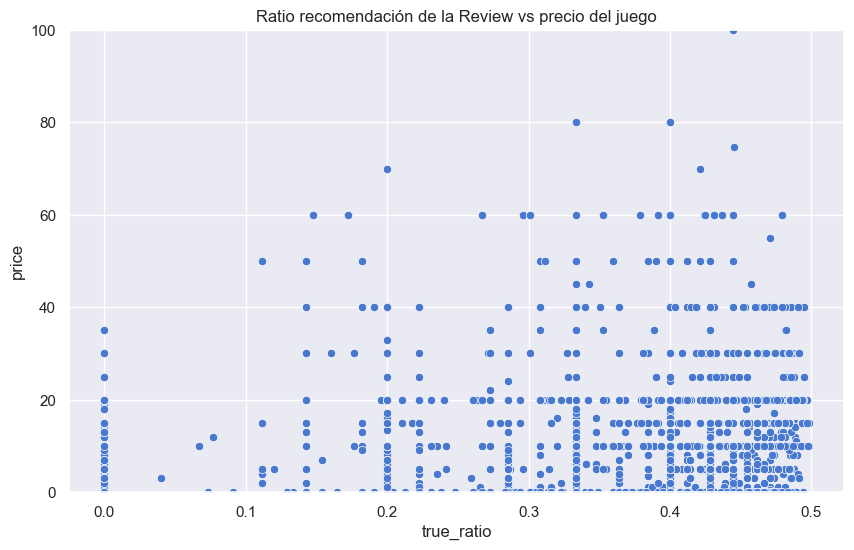

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'true_ratio', y='price', data = df_steam_games)
plt.title('Ratio recomendación de la Review vs precio del juego')
plt.xlabel('true_ratio')
plt.ylabel('price')
plt.ylim(0,100)
plt.show()

- Análisis de precio vs tiempo jugado

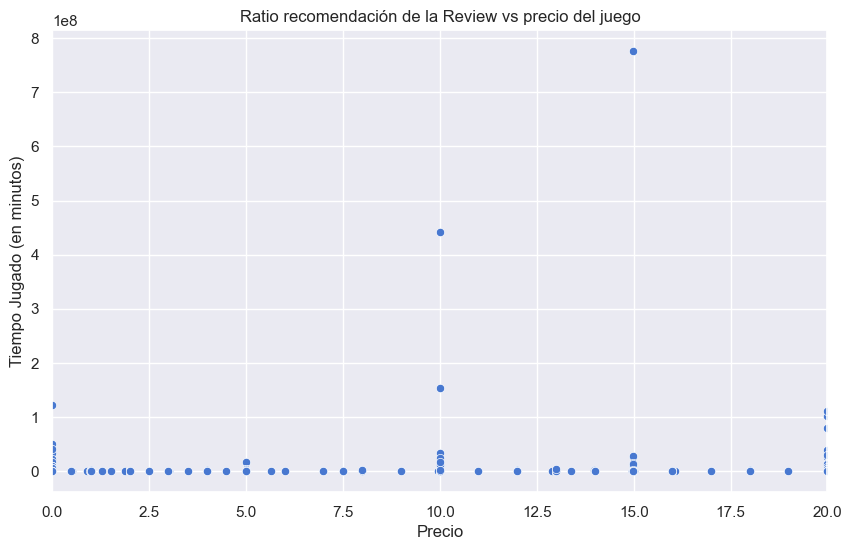

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'price', y='playtime_forever', data = df_steam_games)
plt.title('Ratio recomendación de la Review vs precio del juego')
plt.xlabel('Precio')
plt.ylabel('Tiempo Jugado (en minutos)')
plt.xlim(0,20)
plt.show()

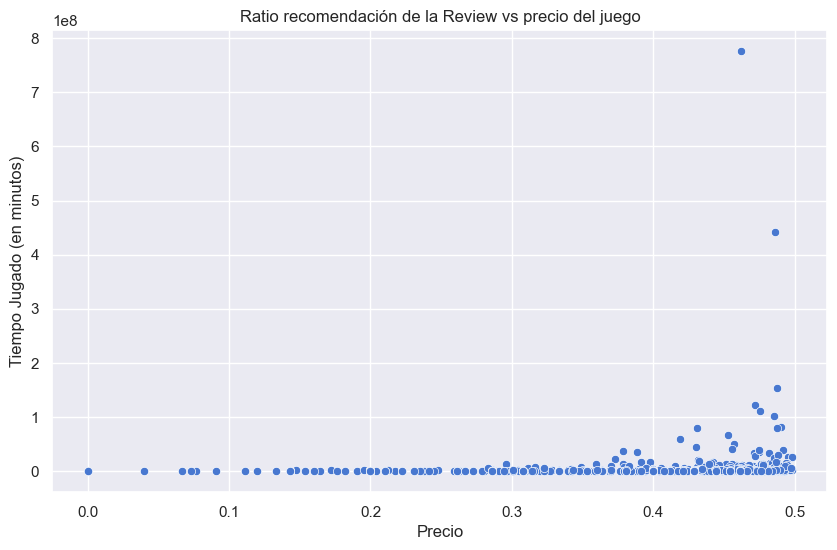

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'true_ratio', y='playtime_forever', data = df_steam_games)
plt.title('Ratio recomendación de la Review vs precio del juego')
plt.xlabel('Precio')
plt.ylabel('Tiempo Jugado (en minutos)')
plt.show()

- Nube de palabras con los nombres de los juegos

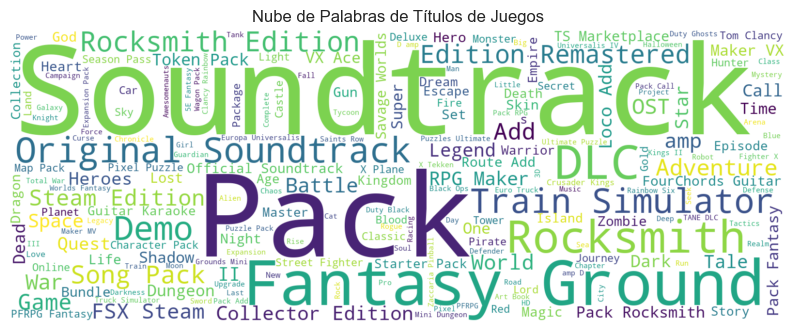

In [42]:
# Concatenar todos los títulos en una sola cadena
text = ' '.join(df_steam_games['title'].dropna())

# Crear la nube de palabras
wordcloud = WordCloud(width=1600, height=600, background_color='white', max_words=200).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Títulos de Juegos')
plt.show()

- Nube de palabras con el resultado del procesamiento NLP

In [43]:
# Convertir los valores de la columna 'processed_reviews' a cadenas de texto y eliminar valores NaN
df_reviews_TF['processed_reviews'] = df_reviews_TF['processed_reviews'].astype(str)

# Función para eliminar caracteres no deseados (como comillas simples o dobles)
def clean_review(review):
    # Eliminar cualquier comilla simple, doble o caracteres especiales
    return re.sub(r"['\"“”‘’]", '', review)

# Aplicar la función de limpieza a cada reseña
df_reviews_TF['processed_reviews'] = df_reviews_TF['processed_reviews'].apply(clean_review)
# Concatenar todas las reseñas en una sola cadena de texto
text = ' '.join(review for review in df_reviews_TF['processed_reviews'].dropna() if isinstance(review, str))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

# Mostrar la nube de palabras con Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Para no mostrar los ejes
plt.show()

NameError: name 'df_reviews' is not defined

In [81]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28542 entries, 0 to 28541
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   publisher         23649 non-null  object        
 1   genres            28542 non-null  object        
 2   app_name          28541 non-null  object        
 3   title             28541 non-null  object        
 4   url               28542 non-null  object        
 5   release_date      28239 non-null  datetime64[ns]
 6   tags              28542 non-null  object        
 7   reviews_url       28542 non-null  object        
 8   specs             28542 non-null  object        
 9   price             27329 non-null  float64       
 10  early_access      28542 non-null  bool          
 11  item_id           28542 non-null  Int64         
 12  developer         28372 non-null  object        
 13  free              28542 non-null  bool          
 14  year              2823

In [44]:
# Guardo el DF en parquet para levantarlo más rápido la próxima vez.
df_steam_games.to_parquet('..\\datasets\\2. Depurado\\steam_games_postEDA.parquet', index=False)